#### Importando as bibliotecas

In [139]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

#### Carregando conjunto de dados

In [140]:
train = pd.read_csv('data/fashion-mnist_train.csv')
test = pd.read_csv('data/fashion-mnist_test.csv')

#### Batch_size 
* O algoritmo coleta as 100 primeiras amostras (de 1 a 100) do conjunto de dados de treinamento (60000) e treina a rede.  

* Em seguida, pega as segundas 100 amostras (de 101 a 200) e treina a rede novamente.

* E vai continuar executando esse procedimento até que tenhamos propagado todas as amostras através da rede. 

In [141]:
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(train) / batch_size)
num_epochs = int(num_epochs)

In [142]:
train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
test.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
train.shape, test.shape

((60000, 785), (10000, 785))

#### Convertendo dataframe para array numpy

In [145]:
train_x = train.drop(columns='label').values

#### Mudando formato do array numpy para 60000 amostras, altura (pixel), largura (pixel)
* Total de pixels = 28 x 28 = 784

In [146]:
train_x = train_x.reshape(train_x.shape[0], 28, 28).astype('float32')

#### Definindo as etiquetas do modelo e convertendo em array numpy

In [147]:
train_y = train['label'].values
train_y

array([2, 9, 6, ..., 8, 8, 7])

In [148]:
np.unique(train_y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Normalização dos dados de treinamento

* 1. X = (X - X.mean) / X.std
* 2. X /= 255. # (based on formula: (X - min) / (max - min) which can converge data into [0, 1].)
* 3. X = 2 * (X - min) / (max - min) - 1 # converge into [-1, 1]

* Dividir por 255 é bom porque todo o intervalo está em [0,1]. Você não pode ter nada menor que 0 e maior que 1.

In [149]:
train_x = train_x / 255

In [150]:
train_x.shape

(60000, 28, 28)

#### Visualizando algumas imagens do conjunto de treinamento

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc2b14fc9d0>,
 <matplotlib.image.AxesImage at 0x7fc2b150b5e0>)

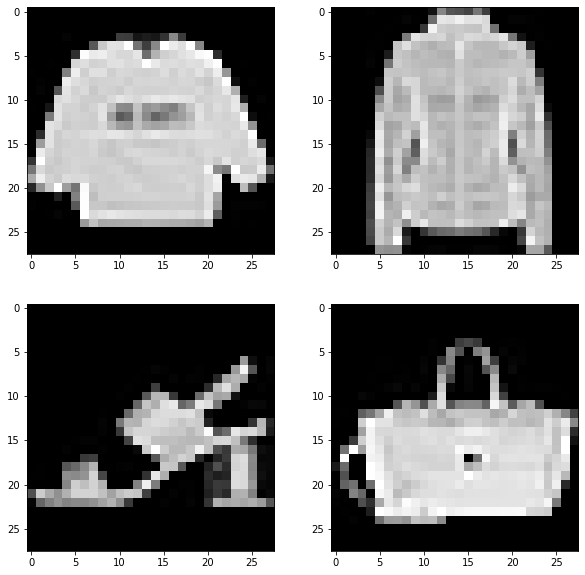

In [151]:
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray')

#### Criação do conjunto de dados de treinamento e validação

In [152]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1)
print((train_x.shape, train_y.shape), (val_x.shape, val_y.shape))

((54000, 28, 28), (54000,)) ((6000, 28, 28), (6000,))


#### Convertendo imagens de treinamento formato torch
* (n_amostras, canais, altura, largura)

In [153]:
train_x = train_x.reshape(54000, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

#### Convertendo as etiquetas em formato torch

In [154]:
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

In [155]:
train_x.shape, train_y.shape

(torch.Size([54000, 1, 28, 28]), torch.Size([54000]))

#### Convertendo o conjunto de validação em formato torch
* (n_amostras, canais, altura, largura) 

In [156]:
val_x = val_x.reshape(6000, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

val_y = torch.from_numpy(val_y)

val_x.shape, val_y.shape

(torch.Size([6000, 1, 28, 28]), torch.Size([6000]))

#### Tensores de empacotamento de conjunto de dados.
* Criando conjunto de treinamento em formato de tensores

In [157]:
train_dataset = torch.utils.data.TensorDataset(train_x,train_y)

#### Carregador de dados. 
* Combina um conjunto de dados e um amostrador e fornece iteradores de um ou vários processos sobre o conjunto de dados.

In [158]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

#### Tensores de empacotamento de conjunto de dados.
* Criando conjunto de validação em formato de tensores

In [159]:
test_dataset = torch.utils.data.TensorDataset(val_x,val_y)

#### Carregador de dados. 
* Combina um conjunto de dados e um amostrador e fornece iteradores de um ou vários processos sobre o conjunto de dados.

In [160]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

#### Inicializando modelo CNN

In [161]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Camada 1
        self.layer1 = nn.Sequential(
        # contém 32 canais de 5x5 filtros convulacionais
        # stride indica quantas etapas estamos movendo em cada etapa da convolução, para formação do feature map
        # padding preenchimento da matriz para tornar a dimensão da saída igual a entrada
        # Seja N o valor da minha dimensão da imagem, F é matriz de filtro do kernel e p o meu padding
        # (N x N) x (F x F) = N x N
        # Aplicando padding
        # (N + 2p) x (N + 2p)
        # (N+2p-F+1)x(N+2p-F+1) Equivalente a NxN
        # N + 2p-F + 1 = N --- (2) 
        # p = (F-1) / 2 --- ( 3)
        # se padding = 0, o maxipooling ira gerar uma amostragem de 12x12
        # 28 + 2x0 - 5 + 1 = N => N = 24
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
        # ativação relu
        nn.ReLU(),
        # maxpooling de amostragem máxima de 2x2, isso gera uma saída de 14x14
        nn.MaxPool2d(kernel_size=2))
        
        # Camada 2
        self.layer2 = nn.Sequential(
        # contém 64 canais de 5x5 filtros convulacionais
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
        # ativação relu
        nn.ReLU(),
        # maxpooling de amostragem máxima de 2x2, isso gera uma saída de 7x7
        nn.MaxPool2d(kernel_size=2))

        #  self.drop_out = nn.Dropout()
        
        # operação de nivelamento que cria 7 x 7 x 64 = 3164 nós, uma camada intermediária de 100 nós totalmente conectados
        # e uma operação de softmax nos 10 nós de saída para produzir probabilidades de classe.
        # m2 é o [c x d] que é [in features x out features]
        self.fc1 = nn.Linear(64 * 7 * 7, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        # formato camada 1 torch.Size([100, 32, 14, 14])
        out = self.layer1(x)
        # formato segunda camada torch.Size([100, 64, 7, 7])
        out = self.layer2(out)
        # m1 [ batch_size x in features]
        # novo formato torch.Size([100, 3136])
        out = out.view(out.size(0), -1)

        # out = self.drop_out(out)
        
        out = self.fc1(out)
        out = self.fc2(out)

        return out

#### Observação
* m1: [a x b], m2: [c x d] tudo o que você precisa cuidar é b = c e está pronto:

* m1 é o [a x b] que é [batch size x in features]

* m2 é o [c x d] que é [in features x out features]

#### Instanciando o modelo da class

In [162]:
model = CNNModel()

#######################
#  USANDO GPU PARA O MODELO CASO TENHA #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNModel(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

#### Instanciando a função de perda para o modelo da classe

In [163]:
criterion = nn.CrossEntropyLoss()

#### Instanciando a função de otimização para o modelo da classe

In [164]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Parâmetros do modelo

In [165]:
print(model.parameters())

print(len(list(model.parameters())))

# Convolução 1: 32 Kernels, 1 canal, filtro de 5x5
print(list(model.parameters())[0].size())

# Convolução 1 Bias: 32 Kernels
print(list(model.parameters())[1].size())

# Convolução 2: 64 Kernels com profundidade = 32 Kernels, filtro de 5x5
print(list(model.parameters())[2].size())

# Convolução 2 Bias: 64 Kernels
print(list(model.parameters())[3].size())

# Camada 1, totalmente conectada
print(list(model.parameters())[4].size())

# Camada de Bias totalmente conectada
print(list(model.parameters())[5].size())

# Camada 2, totalmente conectada
print(list(model.parameters())[6].size())

# Camada de Bias totalmente conectada
print(list(model.parameters())[7].size())

<generator object Module.parameters at 0x7fc2b142c190>
8
torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


#### Treinando o modelo

In [229]:
iter = 0
rate_accuracy = []
rate_loss = []
predictions = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        ######################################
        #  USANDO GPU PARA TREINAR O MODELO  #
        ######################################
        images = images.requires_grad_().to(device)
        labels = labels.to(device)

        # Limpando os parametros dos gradientes
        optimizer.zero_grad()

        # Encaminhar passagem para obter saída / logits
        outputs = model(images)

        # Calcular perda: softmax -> perda de entropia cruzada
        loss = criterion(outputs, labels)

        # Obtendo parametros dos gradientes
        loss.backward()

        # Atualizando parametros
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # calculando a acuracia
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                ######################################
                # USANDO GPU PARA TREINAR O MODELO   #
                ######################################
                images = images.requires_grad_().to(device)
                labels = labels.to(device)

                
                # Passagem direta apenas para obter logits / saída
                outputs = model(images)


                # Obter previsões do valor máximo
                _, predicted = torch.max(outputs.data, 1)


                # Número total de etiquetas
                total += labels.size(0)

                ######################################
                # USANDO GPU PARA TREINAR O MODELO   #
                ######################################
                # Total de previsões corretas
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            rate_accuracy.append(accuracy)
            rate_loss.append(loss.item())
            model.train()
# salvando o modelo
torch.save(model, 'model.pth')

Iteration: 500. Loss: 0.48980697989463806. Accuracy: 85
Iteration: 1000. Loss: 0.3593815267086029. Accuracy: 85
Iteration: 1500. Loss: 0.3753535747528076. Accuracy: 85
Iteration: 2000. Loss: 0.5125153660774231. Accuracy: 85
Iteration: 2500. Loss: 0.4256771206855774. Accuracy: 85
Iteration: 3000. Loss: 0.43046805262565613. Accuracy: 85
Iteration: 3500. Loss: 0.29190531373023987. Accuracy: 85
Iteration: 4000. Loss: 0.2804625630378723. Accuracy: 85
Iteration: 4500. Loss: 0.3822923004627228. Accuracy: 85
Iteration: 5000. Loss: 0.38995105028152466. Accuracy: 85
Iteration: 5500. Loss: 0.27725285291671753. Accuracy: 85
Iteration: 6000. Loss: 0.46680447459220886. Accuracy: 85
Iteration: 6500. Loss: 0.3253055512905121. Accuracy: 85
Iteration: 7000. Loss: 0.3745368719100952. Accuracy: 85
Iteration: 7500. Loss: 0.39146971702575684. Accuracy: 85
Iteration: 8000. Loss: 0.2994441092014313. Accuracy: 85
Iteration: 8500. Loss: 0.47968819737434387. Accuracy: 85


/home/over/anaconda3/envs/dev/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type CNNModel. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [167]:
rate_accuracy = [float(i.numpy()) for i in rate_accuracy]

<function matplotlib.pyplot.show(*args, **kw)>

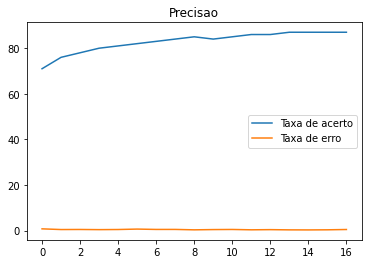

In [168]:
plt.plot(rate_accuracy, label="Taxa de acerto")
plt.plot(rate_loss, label="Taxa de erro")
plt.title("Precisao")
plt.legend()
plt.show

#### Carregando modelo treinado na gpu

In [230]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('model.pth')
model.eval()

CNNModel(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

##### Utilizando o conjunto de dados de teste

In [231]:
test_images = test.drop(columns='label').values
test_label = test['label']

#### Normalizando conjunto de teste para ter a entrada correta, para fazer a predição

In [232]:
test_images = test_images.reshape(test_images.shape[0], 28, 28).astype('float32')
test_images /= 255

#### Gerando imagens de teste e salvando em data

In [264]:
def generate_images_test(dataset_images):
    print("Salvamento em andamento")
    for i in np.random.randint(0, 10000+1, 10):
        print("Salvando images:", i)
        imsave("data/"+str(i)+".jpg", dataset_images[i])
    print("Processo finalizado")

In [265]:
generate_images_test(test_images)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Salvamento em andamento
Salvando images: 7462
Salvando images: 7062
Salvando images: 2857
Salvando images: 6802
Salvando images: 4302
Salvando images: 7041
Salvando images: 2965
Salvando images: 8930
Salvando images: 9507
Salvando images: 971
Processo finalizado


In [266]:
def predict_image(image_path):
    print("Predição em prgresso")
    image = Image.open(image_path)
    
    classes = {0 : 'T-shirt/top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal',
           6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle boot'}

    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))

    ])


    # Pré-processar a imagem
    image_tensor = transformation(image).float()

    # Adicione uma dimensão de lote extra, já que o pytorch trata todas as imagens como lotes
    image_tensor = image_tensor.unsqueeze_(0)
    print(image_tensor.size())

    if torch.cuda.is_available():
        image_tensor.cuda()

    # Transforma a entrada em uma variável
    input = Variable(image_tensor).cuda()

    # Preveja a classe da imagem
    output = model(input)

    index = output.argmax()

    return (int(index.cpu()), classes[int(index.cpu())])

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc2b0948160>,
 <matplotlib.image.AxesImage at 0x7fc2c01e5160>)

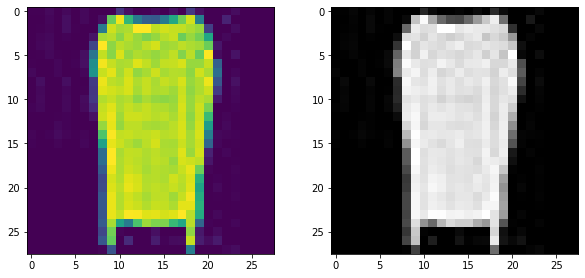

In [267]:
img1 = imread('data/101.jpg')
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(img1)
plt.subplot(222), plt.imshow(img1, cmap='gray')

In [259]:
predict_image('data/101.jpg')

Predição em prgresso
torch.Size([1, 1, 28, 28])


(3, 'Dress')

In [260]:
test_label[101]

3

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc3042f5850>,
 <matplotlib.image.AxesImage at 0x7fc2c9698430>)

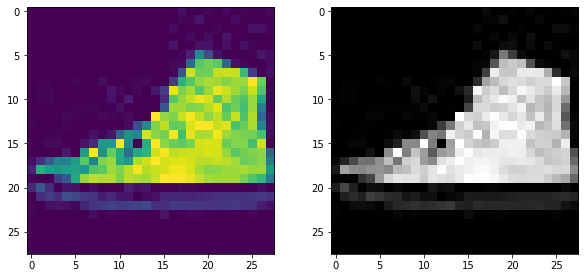

In [273]:
img2 = imread('data/1224.jpg')
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(img2)
plt.subplot(222), plt.imshow(img2, cmap='gray')

In [275]:
predict_image('data/1224.jpg')

Predição em prgresso
torch.Size([1, 1, 28, 28])


(7, 'Sneaker')

In [276]:
test_label[1224]

7

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc2b1428ca0>,
 <matplotlib.image.AxesImage at 0x7fc2b11913a0>)

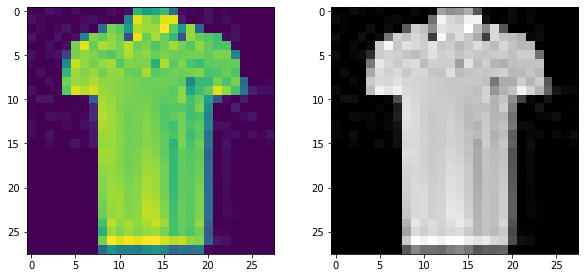

In [274]:
img3 = imread('data/2965.jpg')
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(img3)
plt.subplot(222), plt.imshow(img3, cmap='gray')

In [277]:
predict_image('data/2965.jpg')

Predição em prgresso
torch.Size([1, 1, 28, 28])


(3, 'Dress')

In [278]:
test_label[2965]

0